In [ ]:
using OrdinaryDiffEq
using QuantumAnnealingTools
using Plots

# Close System Examples
## Define the Hamiltonin
We'd like to illustrate some features of OSQAT by simulating the close system dynamics of a 2-level system with Hamiltonian
\begin{equation}
    H(s) = - \sigma_z
\end{equation}
and initial state
\begin{equation}
    \lvert \phi(0) \rangle = \lvert + \rangle \ .
\end{equation}
In this notation, $s$ is the dimensionless time
\begin{equation}
    s = t/t_f
\end{equation}
where $t_f$ is the total evolution time. We use a constant Hamiltonian in this tutorial so we can trivially confirm the simulation result. However, the syntax will be the same for time dependent Hamiltonians. Let's first define the Hamiltonian by:

In [2]:
H = DenseHamiltonian([(s)->1.0], [-σz], unit=:ħ)
u0 = PauliVec[1][1]
# define total evolution time in (ns)
tf = 10
annealing = Annealing(H, u0)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)

In this example, we use the `DenseHamiltonian` object. The syntax is the same for other type of Hamiltonians.

## Schrodinger equation
We start with the Schrodinger equation
\begin{equation}
    \lvert \dot{\phi} \rangle = -i t_f H(s) \lvert \phi \rangle \ .
\end{equation}

### Recommended algorithm
A full list of algorithms supported by `OrdinaryDiffEq` packagae is listed [here](https://docs.sciml.ai/latest/solvers/ode_solve/). We do not guarantee compatibilities to every solver in this list. Users can try specific algorithms if they are interested. We provide a list of algorithms we tested and recommended here:

1. The default Tsitouras 5/4 Runge-Kutta method(Tsit5()).  \
This is the default method in `OrdinaryDiffEq` and works well in most cases.
 
2. A second order A-B-L-S-stable one-step ESDIRK method(TRBDF2()). \
 This is the method widely used in large scale classical circuit simulations. Because this method has order of 2, it is recommended to use smaller error tolerance comparing with other higher order methods.
 
3. A simple linear exponential method(LinearExponential()). \
 This method simply discretize the Hamiltonian and do matrix exponential for each interval.
 
4. Adaptive exponential Rosenbrock methods(Exprb32()/Exprb43()). \
 This method belongs to the adaptive exponential Runge-Kutta method family.
 
It is important to notice that, method 3 and 4 are exponential methods which would preserve the norm of the state vectors.

In [3]:
sol_tsit = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_schrodinger(annealing, tf, alg=TRBDF2(), abstol=1e-6, reltol=1e-6);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_schrodinger(annealing, tf, alg=LinearExponential(), abstol=1e-6, reltol=1e-6, tstops=range(0,1,length=100));
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_schrodinger(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100));

We plot the observable $\langle X \rangle$ w.r.t to dimensionless time `s`.

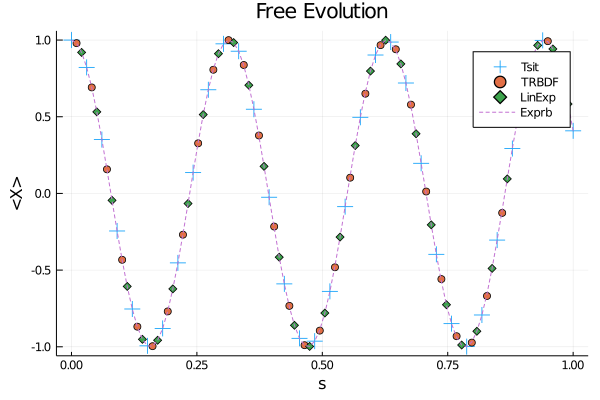

In [4]:
s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    push!(tsit, real(sol_tsit(s)'*σx*sol_tsit(s)))
    push!(trbdf, real(sol_trbdf(s)'*σx*sol_trbdf(s)))
    push!(linexp, real(sol_linexp(s)'*σx*sol_linexp(s)))
    push!(exprb32, real(sol_exprb32(s)'*σx*sol_exprb32(s)))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Free Evolution")

### Rescale the time axis -- from $s$ to $t$
By default, the program will work with the dimensionless time $s$. This can be changed by setting the keyword argument `dimensionless_time` to `false`. As a result, the solution goes from $0$ to $t_f$ as shown below:

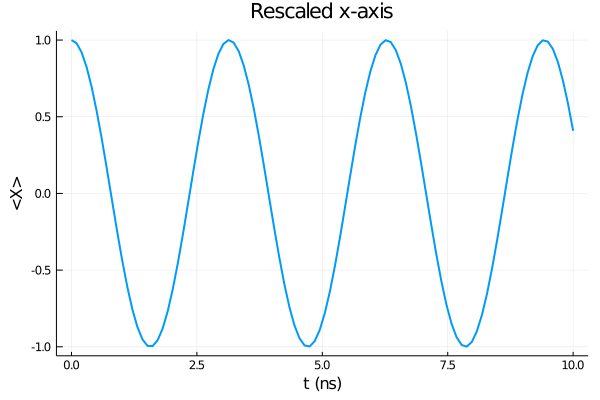

In [5]:
sol_tsit = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6, dimensionless_time=false);
s_list = range(0,tf,length=100)
tsit = [real(sol_tsit(s)'*σx*sol_tsit(s)) for s in s_list]
plot(s_list, tsit, label="", linewidth=2)
xlabel!("t (ns)")
ylabel!("<X>")
title!("Rescaled x-axis")

### Instantaneous pulse control
We can also add instantaneous pulse control to the evolution. For example, by using controller `InstPulseControl`, we can insert a $X$ pulse at $s=0.5$. Here we plot $\langle X \rangle$ with a single $X$ pulse in the middle of the evolution(spin echo).

In [6]:
# The first argument is a list of times where the pulses are aapplied; 
# the second argument is a function with signature (index of the pulse)-> pulse matrix 
control = InstPulseControl([0.5], (x)->σx)
annealing = Annealing(H, u0, control=control)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)

In [7]:
sol_tsit = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_schrodinger(annealing, tf, alg=TRBDF2(), abstol=1e-6, reltol=1e-6);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_schrodinger(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100));
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_schrodinger(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100));

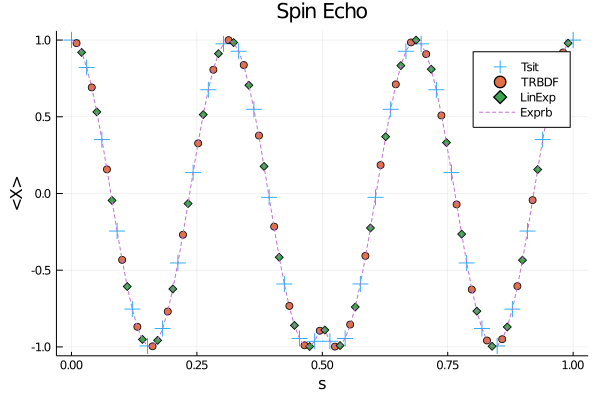

In [8]:
s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    push!(tsit, real(sol_tsit(s)'*σx*sol_tsit(s)))
    push!(trbdf, real(sol_trbdf(s)'*σx*sol_trbdf(s)))
    push!(linexp, real(sol_linexp(s)'*σx*sol_linexp(s)))
    push!(exprb32, real(sol_exprb32(s)'*σx*sol_exprb32(s)))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Spin Echo")

In abvoe figure, the system return to its initial value as we expected.
### Using [DEDataArray](https://docs.sciml.ai/latest/features/diffeq_arrays/#DEDataArrays-1)
One can also use DiffEq-specific array types [DEDataArray](https://docs.sciml.ai/latest/features/diffeq_arrays/#DEDataArrays-1) to record the internal variable used by any controller. An example w.r.t. the instantaneous pulse controller is  given below. First, we define a subtype of `DEDataArray` with an additional field called `state`, which will be used to record the index of pulse needed to be applied at next stop.

In [9]:
# The first field should always be `x` and has the value of the original state vector/density matrix.
mutable struct DEStateMachineArray{T,N} <: DEDataArray{T,N}
    """Array data"""
    x::Array{T,N}
    """Current state"""
    state::Int
end

Second, we define a function to convert a regular state vector/density matrix to `DEStateMachineArray` type. Finally, we define a different controller called `InstDEPulseControl` and specify the field name we used to record the internal state in `DEStateMachineArray`.

In [10]:
# The 1 in the second argument is the initial value of the index
de_wrapper(x) = DEStateMachineArray(x, 1)
control = InstDEPulseControl([0.5], (x)->σx, :state)
annealing = Annealing(H, u0, control=control)
sol = solve_schrodinger(annealing, tf, alg=Tsit5(), de_array_constructor=de_wrapper, abstol=1e-6, reltol=1e-6);

Then, each point of the solution will be a `DEStateMachineArray` type, whose `state` field record the internal pulse index. We can plot it by

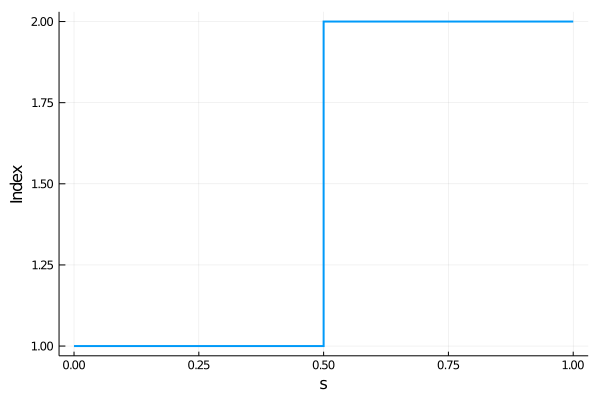

In [11]:
y = [u.state for u in sol.u]
plot(sol.t, y, label="", linewidth=2)
xlabel!("s")
ylabel!("Index")

`InstDEPulseControl` is a subtype to `DEDataControl`. For every controller under `DEDataControl`, a valid `DEDataArray`type must be defined and the corresponding converting function must be provided. Otherwise, the following error would be thrown.

In [ ]:
# the following code will throw out error
sol = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);

## Other close system equations
The package also contains several other close system tools.
### Von Neumann equation
Von Neumann equation is the "Schrodinger" equation for density matrices
\begin{equation}
    \dot{\rho} = -it_f[H(s), \rho] \ .
\end{equation}
Even though Von Neumann equation is equivalent to the Schrodinger equation, it is sometimes numerically more stable than the Schrodinger equation. Users is encouraged to try to solve them using different algorithms.

In [13]:
annealing = Annealing(H, u0)
sol_tsit = solve_von_neumann(annealing, tf, alg=Tsit5(),abstol=1e-6, reltol=1e-6);

As shown below, the solution given by the solver is the density matrix instead of state vector.

In [14]:
sol_tsit(0.5)

2×2 Array{Complex{Float64},2}:
       0.5+0.0im       -0.419535-0.272011im
 -0.419535+0.272011im        0.5+0.0im

### Recommended algorithm
Only explicit methods are supported for solving equations w.r.t. density matrices. [Vectorization] (https://en.wikipedia.org/wiki/Vectorization_(mathematics)) is needed for implicit methods. This can be done by setting `vectorize` keyword argument to be true. For example, in the following block, we solve the Von Neumann equation with TRBDF2 method:

In [15]:
sol_bdf = solve_von_neumann(annealing, tf, alg=TRBDF2(),abstol=1e-9, reltol=1e-9, vectorize=true);

In [16]:
sol_bdf(0.5)

4-element Array{Complex{Float64},1}:
   0.4999999999999999 + 0.0im
 -0.41973677330257747 + 0.27169752326788804im
 -0.41973677330257747 - 0.27169752326788804im
   0.4999999999999999 + 0.0im

As shown above, the solution given by the solver becomes a vectorized version of the density matrix.

Side note: `TRBDF2` can actually work without vectorizing the Von Neumann equation. However, this is not generally true for other algorithms/solvers. For example, we will run into error for `LinearExponential` method if no vectorization is performed.

In [ ]:
# For algorithms that need to calculate the Jacobian explicitly, there will be error without setting `vectorize` to true
sol_linexp = solve_von_neumann(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100));
# the correct version is
sol_linexp = solve_von_neumann(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100), vectorize=true);

We can again plot the $\langle X \rangle$ for different methods, with/without echo pulse.

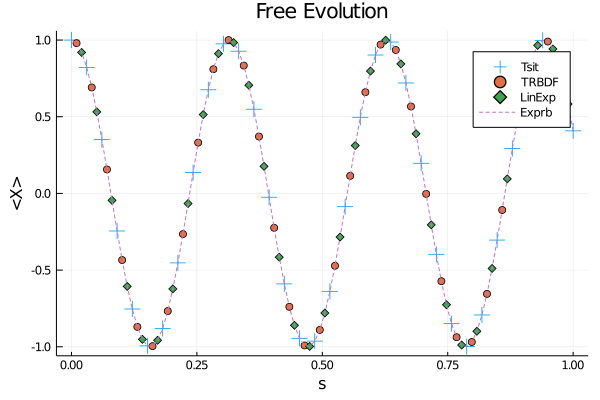

In [18]:
sol_tsit = solve_von_neumann(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_von_neumann(annealing, tf, alg=TRBDF2(), abstol=1e-9, reltol=1e-9);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_von_neumann(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100), vectorize=true);
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_von_neumann(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100), vectorize=true);

s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    push!(tsit, real(tr(sol_tsit(s)*σx)))
    push!(trbdf, real(tr(sol_trbdf(s)*σx)))
    push!(linexp, real(tr(σx*reshape(sol_linexp(s),2,2))))
    push!(exprb32, real(tr(σx*reshape(sol_exprb32(s),2,2))))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Free Evolution")

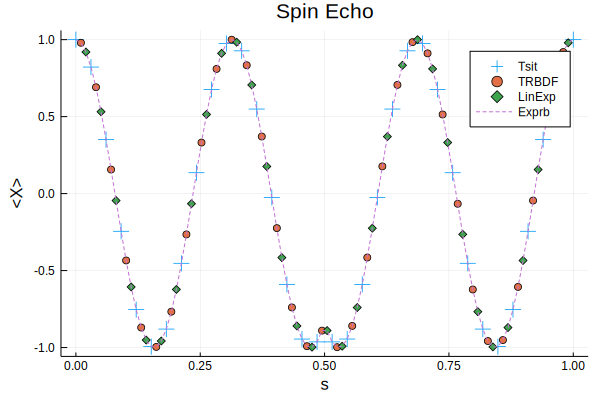

In [18]:
# The first argument is a list of times where the pulses are aapplied; 
# the second argument is a function with signature (index of the pulse)-> pulse matrix 
control = InstPulseControl([0.5], (x)->σx)
annealing = Annealing(H, u0, control=control)
sol_tsit = solve_von_neumann(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_von_neumann(annealing, tf, alg=TRBDF2(), abstol=1e-9, reltol=1e-9);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_von_neumann(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100), vectorize=true);
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_von_neumann(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100), vectorize=true);

s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    push!(tsit, real(tr(sol_tsit(s)*σx)))
    push!(trbdf, real(tr(sol_trbdf(s)*σx)))
    push!(linexp, real(tr(σx*reshape(sol_linexp(s),2,2))))
    push!(exprb32, real(tr(σx*reshape(sol_exprb32(s),2,2))))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Spin Echo")

### Unitary
Finally, we can also solve the unitary
\begin{equation}
    U(s) = T_+ \exp\bigg\{ -i t_f \int_0^s H(s') \mathrm{d}s' \bigg\}
\end{equation}
using `solve_unitary`. The ODE form of the problem is
\begin{equation}
    \dot{U} = -i t_f H(s) U \ .
\end{equation}
Again, although this is in principle equivalent to Schrondinger/Von Neumann equation, the unitary becomes handy in certain cases, e.g. the Redfeild equation.

In [19]:
annealing = Annealing(H, u0)
sol_tsit = solve_unitary(annealing, tf, alg=Tsit5(),abstol=1e-6, reltol=1e-6);

In [20]:
sol_tsit(0.5)

2×2 Array{Complex{Float64},2}:
 0.283662-0.958924im       0.0+0.0im
      0.0+0.0im       0.283662+0.958924im

We can also plot $\langle X \rangle$ for both the free evolution and the spin echo cases using the resulting unitaries.

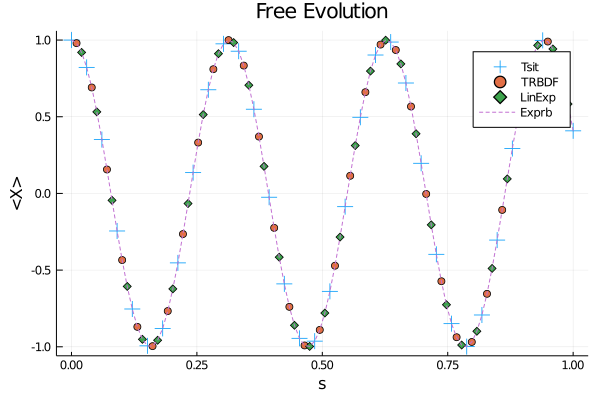

In [21]:
sol_tsit = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_unitary(annealing, tf, alg=TRBDF2(), abstol=1e-9, reltol=1e-9);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_unitary(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100), vectorize=true);
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_unitary(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100), vectorize=true);

s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    state_tsit = sol_tsit(s) * u0
    state_trbdf = sol_trbdf(s) * u0
    state_linexp = reshape(sol_linexp(s), 2, 2) * u0
    state_exprb32 = reshape(sol_exprb32(s), 2, 2) * u0
    push!(tsit, real(state_tsit' * σx * state_tsit))
    push!(trbdf, real(state_trbdf' * σx * state_trbdf))
    push!(linexp, real(state_linexp' * σx * state_linexp))
    push!(exprb32, real(state_exprb32' * σx * state_exprb32))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Free Evolution")

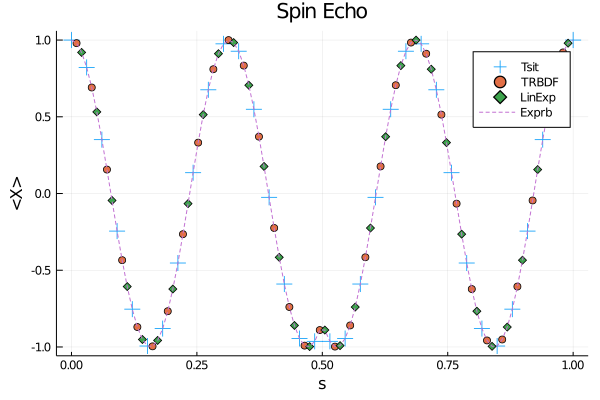

In [22]:
control = InstPulseControl([0.5], (x)->σx)
annealing = Annealing(H, u0, control=control)
sol_tsit = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);
sol_trbdf = solve_unitary(annealing, tf, alg=TRBDF2(), abstol=1e-9, reltol=1e-9);
# LinearExponential is a fixed step size method, user need to specify the time steps using keyword argument `tstops`.
sol_linexp = solve_unitary(annealing, tf, alg=LinearExponential(), tstops=range(0,1,length=100), vectorize=true);
# Even though Exprb method is an adaptive method, it tends to jump a lot of middle points. So if you want accurate evolution in the middle,
# it is better to manually add more points for the algorithm.
sol_exprb32 = solve_unitary(annealing, tf, alg=Exprb32(), tstops=range(0,1,length=100), vectorize=true);

s_list = range(0,1,length=100)
tsit = []
trbdf = []
linexp = []
exprb32 = []
for s in s_list
    state_tsit = sol_tsit(s) * u0
    state_trbdf = sol_trbdf(s) * u0
    state_linexp = reshape(sol_linexp(s), 2, 2) * u0
    state_exprb32 = reshape(sol_exprb32(s), 2, 2) * u0
    push!(tsit, real(state_tsit' * σx * state_tsit))
    push!(trbdf, real(state_trbdf' * σx * state_trbdf))
    push!(linexp, real(state_linexp' * σx * state_linexp))
    push!(exprb32, real(state_exprb32' * σx * state_exprb32))
end
scatter(s_list[1:3:end], tsit[1:3:end], label="Tsit", marker=:+, markersize=8)
scatter!(s_list[2:3:end], trbdf[2:3:end], label="TRBDF")
scatter!(s_list[3:3:end], linexp[3:3:end], label="LinExp", marker=:d)
plot!(s_list, exprb32, label="Exprb", linestyle=:dash)
xlabel!("s")
ylabel!("<X>")
title!("Spin Echo")